![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*vyXO4v0OQsmcctUcx6jL3w.png?)

# Table of Contents
- [1. Introduction](#Introduction)
    - [1.1 Business Understanding](#business-understanding)
- [2. Exploratory Data Analysis and Data Modeling](#eda)
    - [2.1 Data Understanding](#data-understanding)        
    - [2.2 Data Preparation](#data-preparation)  
        - [2.2.1 Missing Value Insepction](#missing-value)
        - [2.2.2 Data Wrangling](#data-wrangling)
        - [2.2.3 Exploratory Data Analysis](#eda)  
        - [2.2.4 Feature Selection](#fs)
    - [2.3 Data Modeling](#dm)
    
- [3. Conclusions](#conclusion)


# 1. Introduction
In this notebook I will analyze the [Sparkify Dataset](https://www.kaggle.com/datasets/kuixizhu/sparkify-small-log) from Udacity Data Scientist Nano Degree Program. It will follow and CRoss Industry Standard Process for Data Mining (CRISP-DM) which is consisted of the following steps:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Result Evaluation and Conclusions

# 1.1 Business Understanding
<a id="business-understanding"></a>

Sparkify is a fictitious music streaming platform with a vast user base engaging with the service daily. Similar to leading platforms such as Spotify and Pandora, users have the option to utilize a free account, which features intermittent advertisements between songs, or to upgrade to a premium account offering ad-free listening and enhanced sound quality for a monthly fee. Given that revenue from premium accounts significantly contributes to the company's overall income, our objective is to develop a classifier capable of identifying potential churn customers, thereby safeguarding millions in revenue for the business.


<a id="data-understanding"></a>
# 2.1 Data Understanding


In [35]:
!pip install pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from pyspark.sql.types import DoubleType
import math
from pyspark.sql.functions import *
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pyspark.ml.feature import StandardScaler,MinMaxScaler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import PCA


pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [36]:
from pyspark.sql import SparkSession

## Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Read in small sparkify dataset for EDA
#event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
event_data = "/kaggle/input/sparkify-small-log/mini_sparkify_event_data.json"
user_log_small = spark.read.json(event_data)
user_log_small.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Since there is no document explaining the meaning of each feature, I will take a look at the data and get a sense of the data. 

In [37]:
user_log_small.toPandas().head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


For the features, they can be divided into 3 categories: user features, song features and user-platform interaction features.



**User Feature**

| Feature    | DataType | Description |
| --- | --- | ---|
|userId|string|user identifier|
|firstName|string|user’s first name|
|lastName|string|user’s last name|
|gender|string(categorical)|user’s gender (M and F)|
|registration|long|user’s registration timestamp|
|level|string(categorical)|subscription level (free and paid)|
|location|string|user’s location|


**Song Feature**

| Feature    | DataType | Description |
| --- | --- | ---|
|song|string|song name|
|artist|string|artist name|
|length|double|song’s length in seconds|

**User-platform Interaction Feature**

| Feature    | DataType | Description |
| --- | ---| ---|
|auth|string(categorical)|authentication level (Logged In, Logged Out, Cancelled, Guest)|
|itemInSession|long|log count in a given session|
|method|string(categorical)|http request method (GET and PUT)|
|page|string(categorical)|type of interaction (NextSong, Home, **Cancellation Confirmation**, etc.)|
|sessionId|long|session to which the log belongs to|
|status|long(categorical)|http status code (200, 307 and 404)|
|ts|long|timestamp of a given log|
|userAgent|string|agent used by the user to access the streaming service|


In the page varaible, **Cancellation Confirmation** is an indicator of customer churn.

<a id="data-preparation"></a>
# 2.2 Data Preparation


Before we conduct any exploration data analysis (EDA), we need to do some data wrangling to proprocess the data.

<a id="missing-value"></a>
# 2.2.1 Missing Value Insepection

In [38]:
from pyspark.sql.functions import isnan, when, count, col,round,asc,desc
nrow = user_log_small.count()
user_log_small.select([round(100*count(when(col(c).isNull(), c))/nrow,2).alias(c) for c in user_log_small.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 20.38| 0.0|     2.91|  2.91|          0.0|    2.91| 20.38|  0.0|    2.91|   0.0| 0.0|        2.91|      0.0|20.38|   0.0|0.0|     2.91|   0.0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+




There are two distinct categories of missing values within the dataset, each pertaining to different aspects of the data:

Song-Related Features: This group comprises attributes directly associated with songs, such as artist, song length, and song title. The proportion of missing values within this category amounts to 20.38% of the entire dataset.

User-Related Features: In contrast, this group encompasses attributes relevant to user profiles, including first name, gender, last name, location, registration, and user agent. The percentage of missing values within this set of features is notably lower, accounting for 2.91% of the dataset.

In [39]:
user_log_small = user_log_small.withColumn('song_na',col('song').isNull())
user_log_small = user_log_small.withColumn('user_na',col('firstName').isNull())

In [40]:
user_log_small.groupBy('song_na','page').count().orderBy(desc('count')).show()

+-------+--------------------+------+
|song_na|                page| count|
+-------+--------------------+------+
|  false|            NextSong|228108|
|   true|                Home| 14457|
|   true|           Thumbs Up| 12551|
|   true|     Add to Playlist|  6526|
|   true|          Add Friend|  4277|
|   true|         Roll Advert|  3933|
|   true|               Login|  3241|
|   true|              Logout|  3226|
|   true|         Thumbs Down|  2546|
|   true|           Downgrade|  2055|
|   true|                Help|  1726|
|   true|            Settings|  1514|
|   true|               About|   924|
|   true|             Upgrade|   499|
|   true|       Save Settings|   310|
|   true|               Error|   258|
|   true|      Submit Upgrade|   159|
|   true|    Submit Downgrade|    63|
|   true|Cancellation Conf...|    52|
|   true|              Cancel|    52|
+-------+--------------------+------+
only showing top 20 rows



In [41]:
user_log_small.groupBy('user_na','auth').count().orderBy(desc('count')).show()

+-------+----------+------+
|user_na|      auth| count|
+-------+----------+------+
|  false| Logged In|278102|
|   true|Logged Out|  8249|
|   true|     Guest|    97|
|  false| Cancelled|    52|
+-------+----------+------+



After comparing the distribution of page and auth in samples with and without missing values, we found that:
1. Song related features are missing in samples where the page equals to **NextSong**.
2. Users realted features are missing in samples where the auth values are **Logged Out** and **Guest**.

Both of these observation makes perfect sense. As we are going to build a classifier on user level, we only need to remove samples containing NULL value in user related features.

In [42]:
user_log_small = user_log_small.na.drop(subset=['firstName'])

<a id="data-wrangling"></a>
# 2.2.2 Data Wrangling

## Define Churn User
Before we conduct feature engineering and EDA, we need to define the churn user.
Here, for each user,  I would definite the user as churn user if **Cancellation Confirmation** ever appear in the user's **page** column.

In [43]:
# Generate churn feature
user_log_small.createOrReplaceTempView('user_log_small_table')

user_churn = spark.sql('''
        SELECT userId,
               MAX(IF(page = "Cancellation Confirmation",1,0)) as churn
        FROM user_log_small_table
        GROUP BY userId
''')

## Feature Engineering



Let's start with the user related features.

### User Feature

| Feature    | DataType | Description |
| --- | --- | ---|
|userId|string|user identifier|
|firstName|string|user’s first name|
|lastName|string|user’s last name|
|gender|string(categorical)|user’s gender (M and F)|
|registration|long|user’s registration timestamp|
|level|string(categorical)|subscription level (free and paid)|
|location|string|user’s location|


I choose gender, level, location and registration as they are informative features.  

**gender**  
- ***gender_cate***: Binary encoding 'M' and 'F' into 1 and 0 for gender representation.


**registraiton**  
- ******registration_duration_day***: The length of time since user's registration (unit: days).

**level**

For the "level" feature, it presents an intriguing insight into user behavior, particularly considering the dynamic nature where users can freely switch between free and paid statuses at any point. Specifically, the following aspects are of interest for each user:


1. **Frequency of Transition**: This denotes the number of times a user switches from free to paid status, reflecting their decision-making patterns.

2. **Reversion Frequency**: Indicates the number of times a user reverts from paid to free status, shedding light on potential dissatisfaction or preference changes.

3. **Average Duration in Free Status**: This metric calculates the average duration a user's account remains in the free level, offering insights into user engagement and retention in the free tier.

4. **Average Duration in Paid Status**: Similarly, this measure computes the average duration a user's account stays in the paid level, revealing patterns of user commitment and investment in premium services.

5. **The User's Latest Account Level**: It is the user's latest account status (free/paid).

6. **Time Since Registration to First Interaction**: This duration reflects the engagement level of users with the platform, capturing their immediacy in utilizing platform features post-registration.

Correspondingly, I will generate these feaures:
- ***free_to_paid***: The number of transitions from free to paid level
- ***paid_to_free***: The number of transitions from paid to free level
- ***level_free_avg_duration_day***: The average duration of time the user account remains in the free level (unit: days)
- ***level_paid_avg_duration_day***: The average duration of time the user account remains in the paid level (unit: days)
- ***last_level***:  The user's lastest account level.last_level - The user's lastest account level.
- ***duration_beforeFirstAction***: The  Duration of time between user registration and the first platform interaction (unit: days)

**location**

Here I will extract the state name and map it to [state-level average household income in the United States](https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xls). This new feature would provide insights into regional socioeconomic status.

- ***location_income***: The average house-hold income of the location




In [44]:
# Generate features related to user gender:
# Feature 1: gender_cate - Mapping gender values: 'M' to 1, 'F' to 0.


user_gender = spark.sql(
    '''
    SELECT userId,
           SUBSTRING_INDEX(ANY_VALUE(location),', ',-1) as location,
           ANY_VALUE(gender) as gender,
           IF(ANY_VALUE(gender)='M',1,0) as gender_code
    FROM user_log_small_table
    GROUP BY userId
    '''
)
    
    


In [45]:
# Generate features related to user registration:
# Feature 1: registration_duration_day - The length of time since user's registration (unit: days).

user_duration = spark.sql('''
    SELECT  userID,
            ROUND((MAX(ts) - MAX(registration))/(1000*3600*24),2) as registration_duration_day
    FROM user_log_small_table
    GROUP BY userId
''')


In [46]:
# Generate features related to user account level transitions and durations:
# Feature 1: free_to_paid - Number of transitions from free to paid level
# Feature 2: paid_to_free - Number of transitions from paid to free level
# Feature 3: level_free_avg_duration_day - Average duration of time the user account remains in the free level (unit: days)
# Feature 4: level_paid_avg_duration_day - Average duration of time the user account remains in the paid level (unit: days)
# Feature 5: last_level - The user's lastest account level.
# Feature 6: duration_beforeFirstAction - Duration of time between user registration and the first platform interaction (unit: days)

user_level_switch = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               IF(level='paid' and LAG(level) over w='free',1,0) AS free_to_paid,
               IF(level='free' and LAG(level) over w='paid',1,0) AS paid_to_free ,    
               IF(LAST(level) over w='paid',1,0) as last_level
        FROM user_log_small_table    
        WINDOW w as (PARTITION BY userId ORDER BY ts)
    )
    
    SELECT userId,
           SUM(free_to_paid) as level_free_to_paid,
           SUM(paid_to_free) as level_paid_to_free,
           ANY_VALUE(last_level) as last_level
    FROM CTE
    GROUP BY userId    
''')


user_level_duration = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               IF(level != LAG(level) over w,1,0) AS change_flag,
               level,
               ts,
               registration
        FROM user_log_small_table    
        WINDOW w as (PARTITION BY userId ORDER BY ts)
    ),
    
    CTE_phase AS(
        SELECT userId,
               SUM(change_flag) over w as phase, 
               level,
               ts,
               registration
        FROM CTE
        WINDOW w as (PARTITION BY userId ORDER BY ts ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
    ),
    
    CTE_phase_duration AS(
        SELECT userId,
               level,
               CASE WHEN phase > 0 THEN ROUND((MAX(ts) - MIN(ts))/(1000*3600*24),2) 
                    WHEN phase = 0 THEN ROUND((MAX(ts) - ANY_VALUE(registration))/(1000*3600*24),2) 
                    END as duration_day ,
               IF(phase = 0,ROUND((MIN(ts) - ANY_VALUE(registration))/(1000*3600*24),2),0) as duration_beforeFirstAction
        FROM CTE_phase
        GROUP BY userId,level,phase     
    ),
    
    RESULT AS(
        SELECT userId,
               level,
               COUNT(*) as phase_cnt,
               ROUND(AVG(duration_day),2) as level_avg_duration_day ,
               SUM(duration_beforeFirstAction) as duration_beforeFirstAction
        FROM CTE_phase_duration
        GROUP BY userId,level
    )
    
    SELECT userId,
           MAX(IF(level="free",phase_cnt,0)) as free_cnt,
           MAX(IF(level="paid",phase_cnt,0)) as paid_cnt,
           MAX(IF(level="free",level_avg_duration_day,0)) as level_free_avg_duration_day,
           MAX(IF(level="paid",level_avg_duration_day,0)) as level_paid_avg_duration_day,
           MAX(duration_beforeFirstAction) as duration_beforeFirstAction
    FROM RESULT
    GROUP BY userId
    
''')

In [47]:
# Genreate feature for location
# Feature 1: location_income - The average house-hold income of the location

state= pd.read_csv("/kaggle/input/states-average-household-income-2018/states.csv")
spark_state = spark.createDataFrame(state)
#spark_state = spark.read.csv("s3://spark-udacity-joo/states.csv", header=True)
spark_state.createOrReplaceTempView('state_table')
getLocation = udf(lambda x:x.split(", ")[-1])

user_log_small = user_log_small.withColumn('location',getLocation(user_log_small.location))
user_log_small.createOrReplaceTempView('user_log_small_table')


location_income = spark.sql('''
    WITH log_state AS(
        SELECT DISTINCT SUBSTRING_INDEX(LOCATION,', ',-1) as state_abb
        FROM user_log_small_table
    ),

    State_Income AS (
        SELECT Abbreviation,
               DOUBLE(REPLACE(Income,",","")) as Income
        FROM  state_table
    )

    SELECT state_abb as location,
           AVG(Income) location_income
    FROM log_state
         JOIN State_Income ON state_abb = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',1),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',2),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',3),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',4),'-',-1) = Abbreviation
    GROUP BY state_abb
    '''
)




Put the new features together and normalize the time-duration realted features.

In [48]:

data_user = user_churn.join(user_gender,on='userId') \
                  .join(user_duration,on='userId') \
                  .join(user_level_switch,on='userId') \
                  .join(user_level_duration,on='userId') \
                  .join(location_income,on='location')

data_user = data_user.withColumn('level_free_avg_duration_ratio',(data_user.level_free_avg_duration_day) /  (data_user.registration_duration_day))
data_user = data_user.withColumn('level_paid_avg_duration_ratio',data_user.level_paid_avg_duration_day /  data_user.registration_duration_day)
data_user = data_user.withColumn('level_free_duration_ratio',data_user.level_free_avg_duration_day * data_user.free_cnt /  data_user.registration_duration_day)
data_user = data_user.withColumn('level_paid_duration_ratio',data_user.level_paid_avg_duration_day * data_user.paid_cnt /  data_user.registration_duration_day)



### Song Feature

| Feature    | DataType | Description |
| --- | --- | ---|
|song|string|song name|
|artist|string|artist name|
|length|double|song’s length in seconds|

In this part, I aim to understand users' behavior patterns, particularly focusing on their song listening habits, including the variety of songs they listen to, whether they listen to full tracks or just parts, and their interaction patterns with the platform. By examining user actions throughout their time on the platform, I seek to uncover insights such as whether users engage with the platform immediately after registration or if they maintain regular interaction over time.

Here I will create these features:  
- ***song_cnt***: The number of song listened by user
- ***distinct_song_cnt***: The number of unique song listened by user
- ***song_entropy***: The entropy of the probability distribution of played songs by user
- ***artist_entropy***:  The entropy of the probability distribution of the artists of played songs by user
- ***song_percent_avg***: The mean value of percentage of a song listened by user.
- ***song_percent_std***: The standard deviation value of percentage of a song listened by user.

- ***action_ts_avg***: The average timing of user actions. 
- ***action_ts_std***: The variability in the timing of user actions.
                          
- ***action_hist_0 ~ action_hist_9*** : Represents the distribution of timestamp of user actions.                                            Each feature (action_hist_i) corresponds to a bin in the histogram of normalized timestamps.
The values represent the frequency of user actions falling into each bin.

In [49]:
user_log_small.createOrReplaceTempView('user_log_small_table')

# Genreate feature for song
# Feature 1: song_cnt - The number of song listened by user
# Feature 2: distinct_song_cnt - The number of unique song listened by user

song_cnt = spark.sql('''     
    SELECT userId,          
           COUNT(song) as song_cnt,
           COUNT(DISTINCT song) as distinct_song_cnt
    FROM user_log_small_table
    WHERE song IS NOT NULL
    GROUP BY userId

''')


In [50]:
# Genreate feature for song
# Feature 1: song_entropy - The entropy of the probability distribution of played songs by user
# Feature 2: artist_entropy - The entropy of the probability distribution of the artists of played songs by user

def entropy(probabilities):
  """Computes entropy of a list of probabilities.

  Args:
    probabilities: A list of probabilities.

  Returns:
    The entropy of the list of probabilities.
  """

  entropy = 0.0
  
  for probability in probabilities: 
    entropy -= probability * math.log2(probability)
  return entropy


entropy_udf = udf(entropy, DoubleType())


song_proba = spark.sql(''' 
    WITH CTE AS(
        SELECT userId,
               song,
               COUNT(*) as song_cnt
        FROM user_log_small_table
        WHERE song IS NOT NULL
        GROUP BY userId,song
    ),
    
    total_table AS(
        SELECT userId,
               COUNT(*) as total_song_cnt
        FROM user_log_small_table
        WHERE song IS NOT NULL
        GROUP BY userId
    )
    
    SELECT userId,
           song,
           song_cnt / total_song_cnt as proba
    FROM CTE 
         JOIN total_table USING(userId)
    
''')

artist_proba = spark.sql(''' 
    WITH CTE AS(
        SELECT userId,
               artist,
               COUNT(*) as artist_cnt
        FROM user_log_small_table
        WHERE artist IS NOT NULL
        GROUP BY userId,artist
    ),
    
    total_table AS(
        SELECT userId,
               COUNT(*) as total_artist_cnt
        FROM user_log_small_table
        WHERE artist IS NOT NULL
        GROUP BY userId
    )
    
    SELECT userId,
           artist,
           artist_cnt / total_artist_cnt as proba
    FROM CTE 
         JOIN total_table USING(userId)    
''')



song_entropy = song_proba.groupBy('userId').agg(entropy_udf(collect_list('proba')).alias('song_entropy'))
artist_entropy = artist_proba.groupBy('userId').agg(entropy_udf(collect_list('proba')).alias('artist_entropy'))


In [51]:
# Genreate feature for song listening behavior 
# Feature 1: song_percent_avg - The mean value of percentage of a song listened by user.
# Feature 2: song_percent_std - The standard deviation value of percentage of a song listened by user.

song_percent = spark.sql(''' 
        WITH CTE AS(
            SELECT userId,
                   CASE WHEN ROUND(100*((LEAD(ts) over w ) - ts) /(1000*length),2) > 100 THEN 100
                        ELSE ROUND(100*((LEAD(ts) over w ) - ts) /(1000*length),2)
                   END as song_percentage
            FROM user_log_small_table         
            WINDOW w as (PARTITION BY userId, sessionId ORDER BY ts)
        )
        
        SELECT userId,
               AVG(song_percentage) as song_percent_avg,
               STD(song_percentage) as song_percent_std
        FROM CTE
        GROUP BY userId
    '''
)


In [52]:
# Genreate feature for the timestamp of user's action
# Feature 1: action_ts_avg - Represents the average timing of user actions,
#                            It is computed as the mean value of the user action's normalized timestamps.
# Feature 2: action_ts_std - Represents the variability in the timing of user actions.
#                            It is computed as the standard deviation of the user action's normalized timestamps.
# Feature 3: action_hist_0 to action_hist_9 - Represents the distribution of timestamp of user actions.
#                                            Each feature (action_hist_i) corresponds to a bin in the histogram of normalized timestamps.
#                                            The values represent the frequency of user actions falling into each bin.
#All metrics are based on the normalized value between 0 and 1 according to the lifespan of the user account.



action_ts = spark.sql('''        
        SELECT userId,
               ((ts -  registration) / ((MAX(ts) over w) - registration)) as ts_percent  
        FROM user_log_small_table        
        WINDOW w as (PARTITION BY userId)        
    '''
)


num_bins = 10

# Define a function to calculate histogram bins with probabilities
def calculate_histogram_bins_prob(timestamps):    
    # Calculate bin size
    bin_size = 0.1
    # Initialize bins
    n = len(timestamps)
    bins = [0.0]*10
    # Iterate over timestamps and increment bin counts
    for ts in timestamps:
        index = int(ts  // bin_size)
        if index==10:
            index-=1
        bins[index] += 1/n
   
    return bins


# Register the UDF
histogram_bins_prob_udf = udf(calculate_histogram_bins_prob, ArrayType(DoubleType()))

# Apply the UDF to calculate histogram bins with probabilities for each user
action_distribution = action_ts.groupBy("userId").agg(histogram_bins_prob_udf(collect_list('ts_percent')).alias("histogram_bins_prob"),
                                                      mean('ts_percent').alias('action_ts_avg'),
                                                      stddev('ts_percent').alias('action_ts_std')
                                                     )

# Split list into columns 
action_distribution = action_distribution.select("userId",
                           action_distribution.histogram_bins_prob[0].alias('action_hist_0'),
                           action_distribution.histogram_bins_prob[1].alias('action_hist_1'),
                           action_distribution.histogram_bins_prob[2].alias('action_hist_2'),
                           action_distribution.histogram_bins_prob[3].alias('action_hist_3'),
                           action_distribution.histogram_bins_prob[4].alias('action_hist_4'),
                           action_distribution.histogram_bins_prob[5].alias('action_hist_5'),
                           action_distribution.histogram_bins_prob[6].alias('action_hist_6'),
                           action_distribution.histogram_bins_prob[7].alias('action_hist_7'),
                           action_distribution.histogram_bins_prob[8].alias('action_hist_8'),
                           action_distribution.histogram_bins_prob[9].alias('action_hist_9'),
                           "action_ts_avg","action_ts_std"
                          )


Putting these new features into the original table

In [53]:
data_action = song_cnt.join(song_entropy,on='userId') \
              .join(artist_entropy,on='userId') \
              .join(song_percent,on='userId') \
              .join(action_distribution,on='userId') \

### User-platform Interaction Feature

| Feature    | DataType | Description |
| --- | ---| ---|
|auth|string(categorical)|authentication level (Logged In, Logged Out, Cancelled, Guest)|
|itemInSession|long|log count in a given session|
|method|string(categorical)|http request method (GET and PUT)|
|page|string(categorical)|type of interaction (NextSong, Home, **Cancellation Confirmation**, etc.)|
|sessionId|long|session to which the log belongs to|
|status|long(categorical)|http status code (200, 307 and 404)|
|ts|long|timestamp of a given log|
|userAgent|string|agent used by the user to access the streaming service|


In [54]:
inter_page = spark.sql('''
    SELECT UserId,
           SUM(IF(page="Submit Downgrade",1,0)) as cnt_page_submitDowngrade,
           SUM(IF(page="Thumbs Down",1,0)) as cnt_page_ThumbsDown,
           SUM(IF(page="Home",1,0)) as cnt_page_Home,
           SUM(IF(page="Downgrade",1,0)) as cnt_page_Downgrade,
           SUM(IF(page="Roll Advert",1,0)) as cnt_page_RollAdvert,
           SUM(IF(page="Logout",1,0)) as cnt_page_Logout,
           SUM(IF(page="Save Settings",1,0)) as cnt_page_SaveSettings,
           SUM(IF(page="About",1,0)) as cnt_page_About,
           SUM(IF(page="Settings",1,0)) as cnt_page_Settings,
           SUM(IF(page="Add to Playlist",1,0)) as cnt_page_AddtoPlaylist,
           SUM(IF(page="NextSong",1,0)) as cnt_page_NextSong,
           SUM(IF(page="Help",1,0)) as cnt_page_Help,
           SUM(IF(page="Upgrade",1,0)) as cnt_page_upgrade,
           SUM(IF(page="Error",1,0)) as cnt_page_Error,
           SUM(IF(page="Submit Upgrade",1,0)) as cnt_page_SubmitUpgrade
    FROM user_log_small_table 
    GROUP BY userId
    
''')

In [55]:
inter_session = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               sessionId,
               (MAX(ts)-MIN(ts))/(1000*3600*24) as session_duration_day
        FROM user_log_small_table 
        GROUP BY userId,sessionId
    )
    
    SELECT userId,
           COUNT(DISTINCT sessionId) session_cnt,
           AVG(session_duration_day) as avg_session_duration_day
    FROM CTE
    GROUP BY userId
''')

Put everything together

In [56]:
data_inter = inter_page.join(inter_session,on='userId')
data_final = data_user.join(data_action,on='userId').join(data_inter,on='userId')

In [57]:
data_final.printSchema()
data_final = data_final.withColumn("cnt_page_ThumbsDown",data_final.cnt_page_ThumbsDown/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Home",data_final.cnt_page_Home/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Downgrade",data_final.cnt_page_Downgrade/data_final.registration_duration_day) \
                       .withColumn("cnt_page_RollAdvert",data_final.cnt_page_RollAdvert/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Logout",data_final.cnt_page_Logout/data_final.registration_duration_day) \
                       .withColumn("cnt_page_SaveSettings",data_final.cnt_page_SaveSettings/data_final.registration_duration_day) \
                       .withColumn("cnt_page_About",data_final.cnt_page_About/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Settings",data_final.cnt_page_Settings/data_final.registration_duration_day) \
                       .withColumn("cnt_page_AddtoPlaylist",data_final.cnt_page_AddtoPlaylist/data_final.registration_duration_day) \
                       .withColumn("cnt_page_NextSong",data_final.cnt_page_NextSong/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Help",data_final.cnt_page_Help/data_final.registration_duration_day) \
                       .withColumn("cnt_page_upgrade",data_final.cnt_page_upgrade/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Error",data_final.cnt_page_Error/data_final.registration_duration_day) \
                       .withColumn("cnt_page_SubmitUpgrade",data_final.cnt_page_SubmitUpgrade/data_final.registration_duration_day) 
    
data_final = data_final.drop("userId","location","gender","level_free_avg_duration_day","level_paid_avg_duration_day")

root
 |-- userId: string (nullable = true)
 |-- location: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- gender_code: integer (nullable = false)
 |-- registration_duration_day: double (nullable = true)
 |-- level_free_to_paid: long (nullable = true)
 |-- level_paid_to_free: long (nullable = true)
 |-- last_level: integer (nullable = true)
 |-- free_cnt: long (nullable = true)
 |-- paid_cnt: long (nullable = true)
 |-- level_free_avg_duration_day: double (nullable = true)
 |-- level_paid_avg_duration_day: double (nullable = true)
 |-- duration_beforeFirstAction: double (nullable = true)
 |-- location_income: double (nullable = true)
 |-- level_free_avg_duration_ratio: double (nullable = true)
 |-- level_paid_avg_duration_ratio: double (nullable = true)
 |-- level_free_duration_ratio: double (nullable = true)
 |-- level_paid_duration_ratio: double (nullable = true)
 |-- song_cnt: long (nullable = false)
 |-- distinct_song_cnt: lo

<a id="eda"></a>
# 2.2.3 Exploratory Data Analysis

In [58]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vec_col = 'corr_features'   
# assemble all vector columns into one vector column
assembler = VectorAssembler(inputCols=data_final.columns, outputCol=vec_col)
corr_df = assembler.transform(data_final).select(vec_col)

# compute the correlation between 'churn' and every feature and the correlation between each pair of features
corr_mat = Correlation.corr(corr_df, vec_col)
# convert the corrlation matrix to a pandas dataframe with column names
corr_values = corr_mat.collect()[0][0].values
corr_mat_pd = pd.DataFrame(corr_values.reshape(-1, len(data_final.columns)), \
                           index=data_final.columns, columns=data_final.columns)


Draw the corrlation among features

<AxesSubplot:>

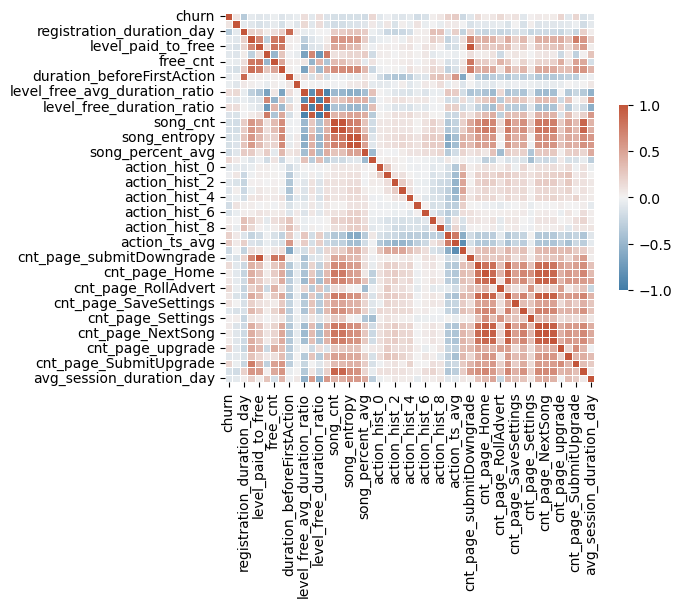

In [59]:
# plot feature correlations
sns.heatmap(corr_mat_pd, vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 20, as_cmap=True), 
            linewidths=.5, cbar_kws={"shrink": .5}, square=True)

Let's delve deeper into the correlation between churn and other features. As anticipated, our feature engineering efforts have proven fruitful, with ***action_ts_avg*** and ***action_ts_std*** emerging as the two features exhibiting the most significant absolute correlation values.

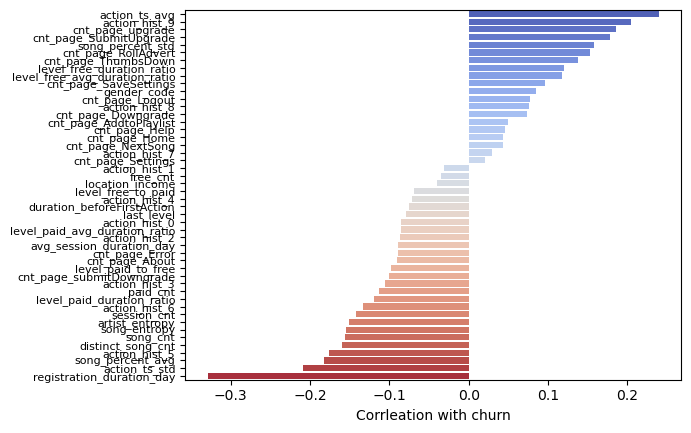

In [60]:
fig,ax = plt.subplots(1,1)
temp_data = corr_mat_pd['churn'].reset_index().query('index!="churn"').sort_values('churn',ascending=False)
sns.barplot(data=temp_data,y='index',x='churn',palette='coolwarm',ax=ax)
ax.set_yticklabels(temp_data['index'],fontsize=8)
ax.set_ylabel('')
ax.set_xlabel('Corrleation with churn')
fig.show()

Now, we will conduct two-sample t-tests for churn and non-churn user groups to determine which features exhibit statistically significant differences between the two groups.

In [61]:
from statsmodels.stats.multitest import multipletests

def ttest(df,group_feature, test_feature):
    flag0 = df[group_feature]==0
    flag1 = ~flag0
    vector_0 = df.loc[flag0,test_feature]
    vector_1 = df.loc[flag1,test_feature]
    statistic, pvalue = stats.ttest_ind(vector_1, vector_0)
    return [statistic,pvalue,test_feature]    


pd_data_final = data_final.toPandas()
ttest_result = []
for c in pd_data_final.columns:
    result = ttest(pd_data_final,'churn',c)
    ttest_result.append(result)

In [62]:
# p-value adjustment for multiple test
df_ttest_result = pd.DataFrame(ttest_result,columns=['stats','pvalue','feature'])
df_ttest_result.sort_values('pvalue')
df_ttest_result['pvalue_adjust'] = multipletests(df_ttest_result['pvalue'],method='fdr_bh')[1]

In [63]:
candidate_feature = df_ttest_result.query('pvalue_adjust<0.05 and feature!="churn"').sort_values('stats')['feature'].to_list()
df_ttest_result.query('pvalue_adjust<0.05 and feature!="churn"')

,stats,pvalue,feature,pvalue_adjust
2,-5.199911,4.505479e-07,registration_duration_day,0.000011
18,-2.765253,6.164242e-03,song_percent_avg,0.043150
25,-2.673427,8.063338e-03,action_hist_5,0.043900
29,3.121131,2.039761e-03,action_hist_9,0.019990
30,3.677763,2.949271e-04,action_ts_avg,0.004817
31,-3.185056,1.654162e-03,action_ts_std,0.019990
44,2.821038,5.218613e-03,cnt_page_upgrade,0.042619
46,2.705654,7.343848e-03,cnt_page_SubmitUpgrade,0.043900


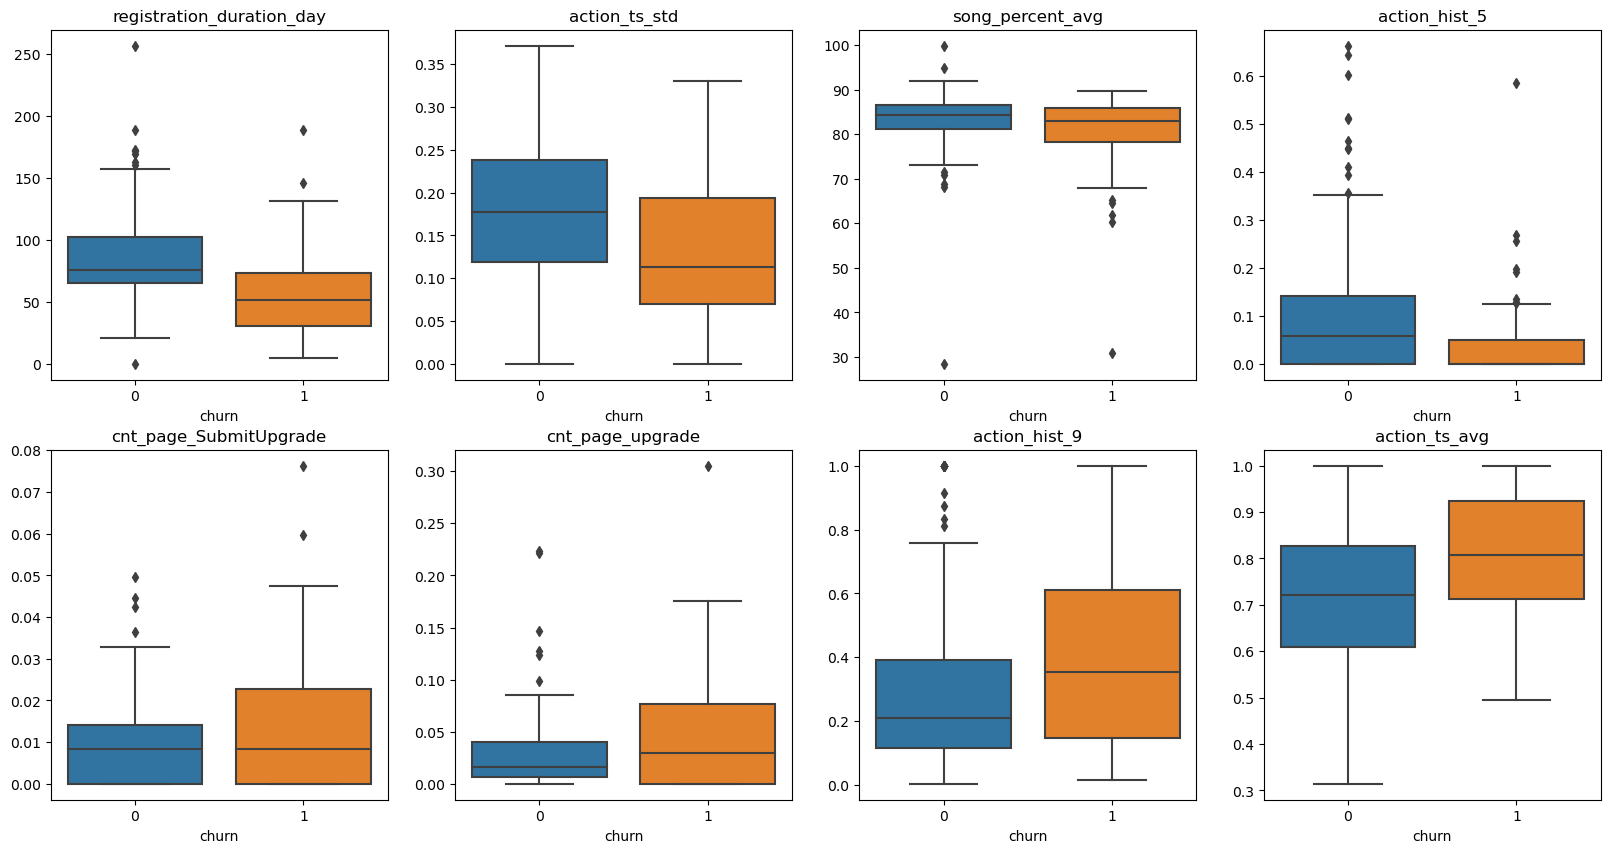

In [64]:
fig, ax = plt.subplots(2,4,figsize=(20,10))
index = 0
for i in range(2):
    for j in range(4):
        sns.boxplot(x="churn",y=candidate_feature[index],data=pd_data_final,ax=ax[i,j])   
        ax[i,j].set_title(candidate_feature[index])
        ax[i,j].set_ylabel('')
        index += 1
fig.show()

***registration_duration_day***  
The feature ***registration_duration_day*** exhibited a highly statistically significant difference (p-value_adjust = 0.000011) between churn and non-churn user groups. This suggests that users who have been registered for a longer duration are less likely to churn. If we aim to reduce the churn rate, our focus should be on new users, as they are more likely to churn within a shorter duration of registration.

***action_ts_avg***  
Regarding ***action_ts_avg*** (the average timestamp of a user's actions normalized by their lifespan), it appears that non-churning users tend to engage with the Sparkify platform earlier after registration compared to churning users. 

***action_ts_std***  
***action_ts_std*** suggests that users with high variability in their usage times are less likely to churn. In essence, users who interact with the platform regularly are more likely to become loyal customers.

***action_hist_5*** and ***action_hist_9***  
Non-churn users show increased interaction in the middle of their customer lifespan, while churn users exhibit a spike just before churn. This suggests specific pre-churn activities. Further investigation into churn user activities before churn could inform mitigation strategies. The boxplot illustrates action frequency distribution across customer lifespan phases. Understanding these patterns aids in tailoring interventions for improved retention.


<AxesSubplot:xlabel='period', ylabel='action'>

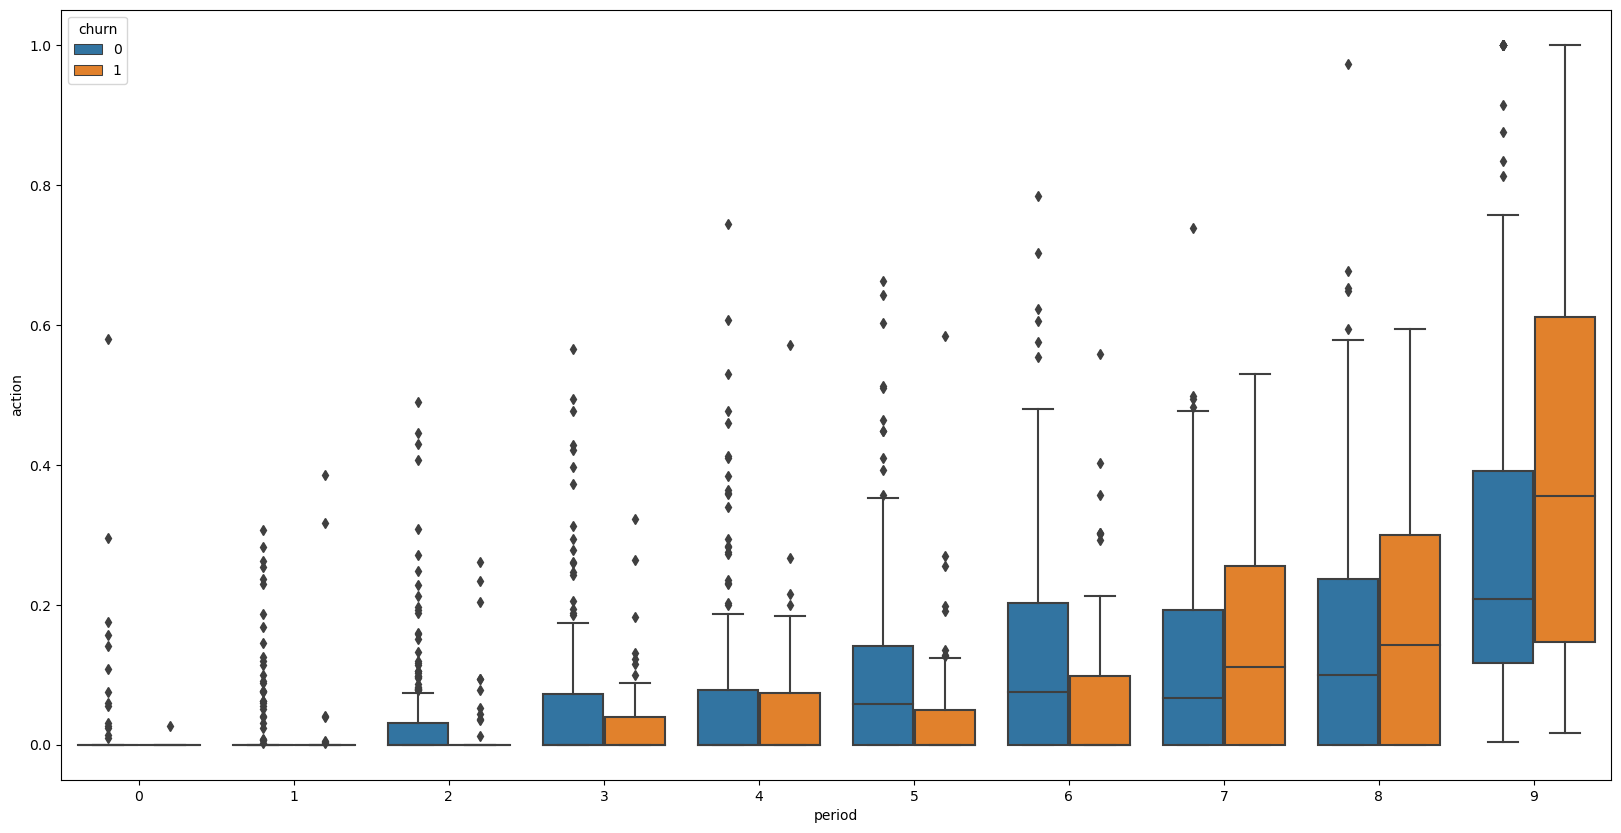

In [65]:
pd_data_final['id'] = range(pd_data_final.shape[0])

df_action = pd.wide_to_long(pd_data_final[['id','churn','action_hist_0','action_hist_1','action_hist_2','action_hist_3','action_hist_4','action_hist_5','action_hist_6','action_hist_7','action_hist_8','action_hist_9']],
                stubnames=['action'],
                i=['id','churn'],
                j= 'period',
                sep='_hist_',
                suffix='.+'
               ).reset_index()

fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(x='period',y='action',data=df_action,hue='churn',ax=ax)

<a id="fs"></a>
# 2.2.4 Feature Selection

Our feature correlation heatmap revealed numerous features with high correlations. To mitigate collinearity, I will identify groups of closely correlated features and select only one from each group for subsequent modeling. This approach aims to streamline the feature set while preserving the most relevant information for our analysis. By reducing redundancy in correlated features, we can enhance model performance and interpretability while avoiding multicollinearity issues that may arise during modeling.


In [66]:
from scipy.sparse import csr_matrix 
from scipy.sparse.csgraph import connected_components

# construct an adjacency matrix where high correlation (> 0.85) is labeled as 1, otherwise 0
is_high_corr = np.abs(corr_mat_pd.values) > 0.85
adj_mat = csr_matrix(is_high_corr.astype(int) - np.eye(len(data_final.columns)))

# find groups of highly correlated features by finding the connected components in the adjacency matrix
_, corr_labels = connected_components(csgraph=adj_mat, directed=False)
unique, unique_counts = np.unique(corr_labels, return_counts=True)
# get groups with size > 1
high_corr_labels = unique[unique_counts > 1]

# if there is at least one group of highly correlated features
if len(high_corr_labels) > 0:
    # map the label indices of highly correlated features to their column names
    print('Highly correlated features include:')
    high_corr_col_dict = {}
    for high_corr_label in high_corr_labels:
        high_corr_col_dict[high_corr_label] = [col_name for corr_label, col_name in zip(corr_labels, data_final.columns) 
                                               if corr_label == high_corr_label]
        print(high_corr_col_dict[high_corr_label])
        
    print('\nFeatures to keep:')
    cols_to_drop = []
    for col_name_list in high_corr_col_dict.values(): 
        # keep the feature that has the highest correlation with 'Churn'
        col_to_keep = corr_mat_pd.loc[col_name_list,'churn'].idxmax()
        print(col_to_keep)
        # remove the other features to avoid multicollinearity 
        col_name_list.remove(col_to_keep)
        corr_mat_pd.drop(index=col_name_list, columns=col_name_list, inplace=True)
        cols_to_drop.extend(col_name_list)
        
data_final = data_final.drop(*cols_to_drop)

Highly correlated features include:
['registration_duration_day', 'duration_beforeFirstAction']
['level_paid_to_free', 'cnt_page_submitDowngrade']
['level_free_avg_duration_ratio', 'level_paid_avg_duration_ratio', 'level_free_duration_ratio', 'level_paid_duration_ratio']
['song_cnt', 'distinct_song_cnt', 'session_cnt']
['song_entropy', 'artist_entropy']
['cnt_page_ThumbsDown', 'cnt_page_Home', 'cnt_page_Downgrade', 'cnt_page_Logout', 'cnt_page_AddtoPlaylist', 'cnt_page_NextSong', 'cnt_page_Help']

Features to keep:
duration_beforeFirstAction
level_paid_to_free
level_free_duration_ratio
session_cnt
artist_entropy
cnt_page_ThumbsDown


<a id="dm"></a>
# 2.3 Data Modeling

In [67]:
# split the data into train, validation and test sets using stratified sampling based on 'churn'
train = data_final.sampleBy('churn', fractions={0: 0.8, 1: 0.8}, seed=42)
test = data_final.subtract(train)

# assign class weight
y_collect = train.select('churn').groupBy('churn').count().collect()
bin_counts = {y['churn']: y['count'] for y in y_collect}
total = np.sum(e for e in bin_counts.values())
n_labels = len(bin_counts)
weights = {bin_: total/(n_labels*count) for bin_, count in bin_counts.items()}
train = train.withColumn('weight', when(col('churn')==1.0, weights[1]).otherwise(weights[0]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


<a id="pipe"></a>
##  2.3.1  Building the Pipeline and Hyperparameter tuning


## Performance metrics
In selecting evaluation metrics, I opted for AUC-PR and F1 instead of AUC-ROC. AUC-PR specifically assesses classifier performance with emphasis on the positive class, making it particularly advantageous for imbalanced datasets, which is the case here. This choice allows for a more nuanced evaluation that prioritizes model performance in scenarios where correctly identifying positive instances, such as churn cases, is of paramount importance.

In [68]:
assembler = VectorAssembler(inputCols=[c for c in train.columns if c not in ['churn','weight']], outputCol="NumFeatures")
#scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withMean=True,withStd=True)
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")

# logistic regression
lr = LogisticRegression(featuresCol='ScaledNumFeatures', labelCol='churn')
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# random forest
rf = RandomForestClassifier(featuresCol='ScaledNumFeatures', labelCol='churn', seed=42,)
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])

# logistic regression
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.01, 0.1,0.5],) \
            .addGrid(lr.maxIter, [10, 20,40]) \
             .build()

crossval_lr = CrossValidator(estimator = pipeline_lr,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderPR'),
                             numFolds=3)

# random forest
paramGrid_rf = ParamGridBuilder() \
              .addGrid(rf.numTrees, [50, 100, 150]) \
              .addGrid(rf.maxDepth, [10, 20]) \
              .build()

crossval_rf = CrossValidator(estimator = pipeline_rf,
                             estimatorParamMaps = paramGrid_rf,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderPR'),
                             numFolds=3)


In [69]:
def print_metrics(pred, label='churn'):
    """Print evaluation metrics on a test set
    
    Args:
    pred: (spark dataframe) a test set 
    
    Returns:
    summary: (pandas dataframe) a summary of evaluation metrics
    """
    eval_metrics = {}

    # compute area under PR curve
    evaluator = BinaryClassificationEvaluator(labelCol=label)
    auc_pr = evaluator.evaluate(pred, {evaluator.metricName:'areaUnderPR'})
    auc_roc = evaluator.evaluate(pred, {evaluator.metricName: 'areaUnderROC'})
    # compute precision, recall and f1 score
    predictionAndLabels = pred.select('prediction', label)
    # both 'prediction' and label in predictionAndLabels need to be cast to float type and 
    # map to tuple before calling 'MulticlassMetrics'
    metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

    # get overall statistics
    eval_metrics['overall'] = [metrics.weightedPrecision, metrics.weightedRecall, \
                               metrics.weightedFMeasure(), auc_pr,auc_roc]
                               
    # get statistics by class
    classes = [0.0, 1.0]
    for cls in classes:
        eval_metrics['class ' + str(int(cls))] = [metrics.precision(cls), metrics.recall(cls), \
                                                  metrics.fMeasure(cls), '','']

    # convert to a pandas dataframe for display
    summary = pd.DataFrame.from_dict(eval_metrics, orient='index', \
                                     columns=['precision', 'recall', 'f1 score', 'AUC-PR','AUC-ROC'])   
    
    return summary

In [ ]:
cv_lr = crossval_lr.fit(train)
test_prediction = cv_lr.transform(test)
print_metrics(test_prediction)

In [ ]:
cv_rf = crossval_rf.fit(train)
test_prediction = cv_rf.transform(test)
print_metrics(test_prediction)

<a id="conclusion"></a>
# 3. Conclusion


| Algorithm    | Best Parameter | <td colspan=2> **Precision** | <td colspan=2> **Recall**| <td colspan=2> **F1-Score** | AUC-ROC | AUC-PR |
| --- | --- | --- | --- | --- | --- | --- |
|     |  | <td colspan=1> Overall <td colspan=1> Churned | <td colspan=1> Overall <td colspan=1> Churned| <td colspan=1> Overall <td colspan=1> Churned | |  |
|Logistic Regression|RegParam=0.01, ElasticNetParam=0.5, MaxIter=20|<td colspan=1>0.81 <td colspan=1>0.53|<td colspan=1>0.77 <td colspan=1>0.77|<td colspan=1>0.78 <td colspan=1>0.63|0.80|0.85|
|Random Forest|NumTrees=100, MaxDepth=15|<td colspan=1>0.84 <td colspan=1>1.00|<td colspan=1>0.80 <td colspan=1>0.22|<td colspan=1>0.74 <td colspan=1>0.36|0.69|0.83|
    
    
 Based on the solid performance on the mini dataset, we decide to use logistic regression classifier for future training and examine the feature importance in this model.

In [ ]:
importances = [coef for coef in cv_lr.bestModel.stages[-1].coefficients]
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# plot feature importance
sns.barplot(data=feat_imp_pd, y="feature", x="importance", palette='coolwarm', zorder=2)
plt.grid(axis='x', linestyle='--', zorder=0)
plt.ylabel('');

### Obseration  
The positive impact of increased interactions with ***ThumbsDown*** and ***RollAdvert*** pages on user churn is intuitive. However, noteworthy features include ***SubmitUpgrade*** and ***SaveSettings***. It's conceivable that churn users were dissatisfied with their current settings or account configuration, leading them to attempt changes through settings adjustments or account upgrades. Additionally, the high frequency of advertisements between songs may have been particularly bothersome, potentially contributing to churn. This annoyance could also be related to users' difficulties in finding songs or artists they enjoy, as suggested by ***artist_entropy*** and ***song_percent_std***. Rather than sticking to specific artists and listening to songs in full, churn users may have been frantically browsing songs in hopes of discovering ones they like.

### Busines Impact  
Deploying the predictive model enables Sparkify to proactively identify potential churners among its user base. By offering attractive perks and incentives to these users, Sparkify can effectively reduce churn rates and bolster revenue streams.  

Moreover, the analysis yields valuable business insights that inform strategic improvements:  

**Enhancing Sparkify's Settings**  
Delving into the settings adjustments attempted by churn users offers crucial insights into their dissatisfaction. Understanding the specific settings they sought to change provides actionable intelligence for enhancing user experiences.  

**Optimizing the Recommendation System**    
  Exploring churn users' favorite songs or artists sheds light on their preferences and unveils opportunities for refining the recommendation system. Addressing the system's cold start problem by collecting more user preference information upfront can elevate user satisfaction and retention. Additionally, if desired content is absent from Sparkify's catalog, exploring avenues to acquire copyright licenses may be necessary to meet user expectations and curb churn rates.  

### Future Work
**Advanced Feature Engineering**  
Introducing more sophisticated feature engineering techniques can enhance the predictive power of the model. For instance, incorporating time-series related features such as auto-correlation can help identify patterns in user behavior, such as regular usage patterns of Sparkify.

**Early Churn Prediction**  
While our current study focuses on predicting churn using churned customer's full lifespan data, there's potential to develop models for early churn prediction. We'll focus on early churn prediction by truncating churned customer's late-stage lifespan data. This allows us to detect churn behavior earlier, enabling proactive retention strategies.
